In [118]:
import pandas as pd, numpy as np, os, gc, matplotlib.pyplot as plt, seaborn as sb, re, warnings, calendar, sys
from numpy import arange
get_ipython().run_line_magic('matplotlib', 'inline')
warnings.filterwarnings('ignore'); np.set_printoptions(suppress=True); pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)
global directory; directory = '../input'

def files(): return os.listdir(directory)

def read_clean(data):
    data.columns = [str(x.lower().strip().replace(' ','_')) for x in data.columns]
    seen = {}; columns = []; i = 0
    for i,x in enumerate(data.columns):
        if x in seen: columns.append(x+'_{}'.format(i))
        else: columns.append(x)
        seen[x] = None
        
    for x in data.columns[data.count()/len(data) < 0.0001]: del data[x];
    gc.collect();
    try: data = data.replace({'':np.nan,' ':np.nan});
    except: pass;
    
    if len(data) < 10000: l = len(data);
    else: l = 10000;
    sample = data.sample(l);size = len(sample);
    
    for x in sample.columns:
        ints = pd.to_numeric(sample[x], downcast = 'integer', errors = 'coerce')
        if ints.count()/size > 0.97:
            minimum = ints.min()
            if minimum > 0: data[x] = pd.to_numeric(data[x], downcast = 'unsigned', errors = 'coerce')
            else: data[x] = pd.to_numeric(data[x], downcast = 'integer', errors = 'coerce')
        else:
            floats = pd.to_numeric(sample[x], downcast = 'float', errors = 'coerce')
            if floats.count()/size > 0.97: data[x] = pd.to_numeric(data[x], downcast = 'float', errors = 'coerce')
            else:
                dates = pd.to_datetime(sample[x], errors = 'coerce')
                if dates.count()/size > 0.97: data[x] = pd.to_datetime(data[x], errors = 'coerce')
    return data.reset_index(drop = True)

def read(x):
    '''Kaggle Reading in CSV files.
    Just type read('file.csv'), and you'll get back a Table.'''
    
    file = '{}/{}'.format(directory,x)
    try:     data = pd.read_csv(file)
    except:  data = pd.read_csv(file, encoding = 'latin-1')
    return read_clean(data)

def tally(column, minimum = 0, top = None, graph = False, percent = False, multiple = False, lowercase = False, min_count = 1, method = 'count'):
    '''Provides a tally count of all values in a COLUMN.
        1. minimum  =  (>0)          Least count of item to show.
        2. top      =  (-1,>0)       Only show top N objects
        3. graph    =  (False,True)  Show bar graph of results
        4. percent  =  (False,>0)    Instead of showing counts, show percentages of total count
        
       multiple = False/True.
       If True, counts and tallies objects in list of lists (Count Vectorizer)
       
       lowercase = True / False.
       If True, lowers all text firsrt. So A == a
       
       min_count >= 1
       If a column sum for tag has less than min_count, discard whole column
       
       method == count | tfidf
       Can choose normal bag of words (count) or tfidf (Term Document Frequency)
    '''
    if multiple == False:
        counts = column.value_counts().astype('uint')
        counts = counts[counts >= minimum][:top]
        counts = pd.DataFrame(counts).reset_index()
        counts.columns = [column.name, 'tally']
        if percent: 
            counts['tally'] /= counts['tally'].sum()/100
            counts['tally'] = counts['tally']
        if graph:
            C = counts[::-1]
            C.plot.barh(x = column.name, y = 'tally', legend = False); plt.show();
        return counts
    else:
        column = column.fillna('<NAN>')
        if type(column.iloc[0]) != list: column = column.apply(lambda x: [x])

        if method == 'count':
            from sklearn.feature_extraction.text import CountVectorizer
            counter = CountVectorizer(lowercase = lowercase, tokenizer = lambda x: x, dtype = np.uint32, min_df = min_count)
        else:
            from sklearn.feature_extraction.text import TfidfVectorizer
            counter = TfidfVectorizer(lowercase = lowercase, tokenizer = lambda x: x, dtype = np.float32, min_df = min_count)
        counter.fit(column)
        counts = pd.DataFrame(counter.transform(column).toarray())
        if column.name is None: column.name = 'text'
        counts.columns = [column.name+'_('+str(x)+')' for x in counter.get_feature_names()]
        return counts
    
    
def describe(data):
    '''Provides an overview of your data
        1. dtype    =  Column type
        2. missing% =  % of the column that is missing
        3. nunique  =  Number of unique values in column
        4. top3     =  Top 3 most occuring items
        5. min      =  Minimum value. If not a number column, then empty
        6. mean     =  Average value. If not a number column, then empty
        7. median   =  Middle value. So sort all numbers, and get middle. If not a number column, then empty
        8. max      =  Maximum value. If not a number column, then empty
        9. sample   =  Random 2 elements
        10. name    =  Column Name
    '''
    dtypes = dtype(data)
    length = len(data)
    missing = ((length - data.count())/length*100)
    
    N = [];    most3 = []
    for dt,col in zip(dtypes,data.columns):
        if dt != 'datetime':
            U = data[col].value_counts()
            N.append(len(U))
            if U.values[0] > 1: most3.append(U.index[:3].tolist())
            else: most3.append([]);
        else: N.append(0); most3.append([]);
            
    df = pd.concat([dtypes, missing], 1)
    df.columns = ['dtype','missing%']
    df['nunique'] = N; df['top3'] = most3
    
    numbers = list(data.columns[df['dtype'].isin(('uint','int','float'))])
    df['min'] = data.min()
    df['mean'] = data[numbers].mean()
    df['median'] = data[numbers].median()
    df['max'] = data.max()
    df['sample'] = data.apply(lambda x : x.sample(2).values.tolist())
    df['name'] = list(data.columns)
    return df.sort_values(['missing%', 'nunique', 'dtype'], ascending = [False, False, True]).reset_index(drop = True)


def Checker(x):
    if type(x) is pd.DataFrame: return 0
    elif type(x) is pd.Series: return 1
    else: return -1

def columns(data): return list(data.columns)
def rows(data): return list(data.index)
def index(data): return list(data.index)
def head(data, n = 10): return data.head(n)
def tail(data, n = 10): return data.tail(n)
def sample(data, n = 10): return data.sample(n)

def dtype(data):
    what = Checker(data)
    if what == 0:
        dtypes = data.dtypes.astype('str')
        dtypes = dtypes.str.split(r'\d').str[0]
    else:
        dtypes = str(data.dtypes)
        dtypes = re.split(r'\d', dtypes)[0]
    return dtypes

def mean(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        return data[numbers].mean()
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt: return data.mean()
        else: return np.nan
    else:
        try:     return np.nanmean(data)
        except:  return np.nan
        
def std(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        return data[numbers].std()
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt: return data.std()
        else: return np.nan
    else:
        try:     return np.nanstd(data)
        except:  return np.nan
        
def var(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        return data[numbers].var()
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt: return data.var()
        else: return np.nan
    else:
        try:     return np.nanvar(data)
        except:  return np.nan
        
def log(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        x = np.log(data[numbers])
        x[np.isinf(x)] = np.nan
        return pd.Series(x)
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt:
            x = np.log(data)
            x[np.isinf(x)] = np.nan
            return x
        else: return np.nan
    else:
        try:
            x = np.log(data)
            x[np.isinf(x)] = np.nan
            return x
        except:  return np.nan
        
def median(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        return data[numbers].median()
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt: return data.median()
        else: return np.nan
    else:
        try:     return np.nanmedian(data)
        except:  return np.nan
        
def minimum(data):
    what = Checker(data)
    if what == 0:      return data.min()
    elif what == 1:    return data.min()
    else:              return np.min(data)
        
def maximum(data):
    what = Checker(data)
    if what == 0:      return data.max()
    elif what == 1:    return data.max()
    else:              return np.max(data)
    
def missing(data):
    what = Checker(data)
    if what >= 0:      return pd.isnull(data)
    else:              return np.isnan(data)
    
def count(data):
    what = Checker(data)
    if what >= 0:      return data.count()
    else:              return len(data)
    
def nunique(data):
    what = Checker(data)
    if what >= 0:      return data.nunique()
    else:              return len(np.unique(data))
    
def unique(data):
    if type(data) is pd.DataFrame:
        uniques = []
        for x in data.columns:
            uniques.append(data[x].unique())
        df = pd.Series(uniques)
        df.index = data.columns
        return df
    elif type(data) is pd.Series: return data.unique()
    else:              return np.unique(data)
    
def total(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        return data[numbers].sum()
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt: return data.sum()
        else: return np.nan
    else:
        try:     return np.nansum(data)
        except:  return np.nan
        
def time_number(date): return hours(date)+minutes(date)/60+seconds(date)/60**2
def hours_minutes(date): return hours(date)+minutes(date)/60
def hours(date): return date.dt.hour
def minutes(date): return date.dt.minute
def seconds(date): return date.dt.second
def month(date): return date.dt.month
def year(date): return date.dt.year
def day(date): return date.dt.day
def weekday(date): return date.dt.weekday
def leap_year(date): return year(date).apply(calendar.isleap)
def date_number(date): return year(date)+month(date)/12+day(date)/(365+leap_year(date)*1)
def year_month(date): return year(date)+month(date)/12

def hcat(*columns):
    cols = []
    for c in columns:
        if c is None: continue;
        if type(c) in (list, tuple): 
            for i in c:
                if type(i) not in (pd.DataFrame, pd.Series): cols.append(pd.Series(i))
                else: cols.append(i)
        elif type(c) not in (pd.DataFrame, pd.Series): cols.append(pd.Series(c))
        else: cols.append(c)
    out = pd.concat(cols, 1)
    columns = []
    seen = {}
    for i,x in enumerate(out.columns):
        if x not in seen:
            columns.append(x)
            seen[x] = 0
        else:
            columns.append(x+f'_{i}')
    out.columns = columns
    return out

def vcat(*columns):
    cols = []
    for c in columns:
        if c is None: continue;
        if type(c) in (list, tuple): 
            for i in c:
                if type(i) not in (pd.DataFrame, pd.Series): cols.append(pd.Series(i))
                else: cols.append(i)
        elif type(c) not in (pd.DataFrame, pd.Series): cols.append(pd.Series(c))
        else: cols.append(c)
    return pd.concat(cols, 0)

def melt(data, columns):
    '''Converts a dataset into long form'''
    return data.melt(id_vars = columns)
    
def tabulate(*columns, method = 'count'):
    '''Splits columns into chunks, and counts the occurences in each group.
        Remember - tabulate works on the LAST column passed.
        Options:
            1. count            = Pure Count in group
            2. count_percent    = Percentage of Count in group
            3. mean             = Mean in group
            4. median           = Median in group
            5. max              = Max in group
            6. min              = Min in group
            7. sum_percent      = Percentage of Sum in group
        Eg:
            Apple | 1
            ---------
            Orange| 3
            ---------
            Apple | 2
            ---------
        Becomes:
            Apple | 1 | 1
            -------------
                  | 2 | 1
            -------------
            Orange| 3 | 1
        
        NOTE --------
            method can be a list of multiple options.
    '''
    if type(method) in (list, tuple):
        xs = []
        for x in method:
            g = tabulate(*columns, method = x)
            xs.append(g)
        xs = hcat(xs)
        xs = xs.T.drop_duplicates().T
        return read_clean(xs)        
    else:
        def percent(series):
            counts = series.count()
            return counts.sum()

        data = hcat(*columns)
        columns = data.columns.tolist()

        if method in ('count', 'count_percent'):
            groups = data.groupby(data.columns.tolist()).apply(lambda x: x[data.columns[-1]].count())

            if method == 'count_percent':
                groups = groups.reset_index()
                groups.columns = list(groups.columns[:-1])+['Group_Count']
                right = data.groupby(columns[:-1]).count().reset_index()
                right.columns = list(right.columns[:-1])+['Group_Sum']

                groups = pd.merge(left = groups, right = right, left_on = columns[:-1], right_on = columns[:-1])
                groups['Percent%'] = groups['Group_Count']/groups['Group_Sum']*100
                groups = groups[columns+['Percent%']]
                return groups

        elif method == 'mean': groups = data.groupby(data.columns.tolist()[:-1]).apply(lambda x: x[data.columns[-1]].mean())
        elif method == 'median': groups = data.groupby(data.columns.tolist()[:-1]).apply(lambda x: x[data.columns[-1]].median())
        elif method == 'max': groups = data.groupby(data.columns.tolist()[:-1]).apply(lambda x: x[data.columns[-1]].max())
        elif method == 'min': groups = data.groupby(data.columns.tolist()[:-1]).apply(lambda x: x[data.columns[-1]].min())
        elif method == 'sum_percent':
            groups = data.groupby(data.columns.tolist()[:-1]).apply(lambda x: x[data.columns[-1]].sum()).reset_index()
            groups.columns = list(groups.columns[:-1])+['Group_Count']
            right = data.groupby(columns[:-1]).sum().reset_index()
            right.columns = list(right.columns[:-1])+['Group_Sum']

            groups = pd.merge(left = groups, right = right, left_on = columns[:-1], right_on = columns[:-1])
            groups['Sum%'] = groups['Group_Count']/groups['Group_Sum']*100
            groups = groups[cols+['Sum%']]
            return groups
        else:
            print('Method does not exist. Please choose count, count_percent, mean, median, max, min, sum_percent.'); return None;
        #except: print('Method = {}'.format(method)+' cannot work on Object, Non-Numerical data. Choose count.'); return None;

        groups = pd.DataFrame(groups)
        groups.columns = [method]
        groups.reset_index(inplace = True)
        return groups


def sort(data, by = None, how = 'ascending', inplace = False):
    ''' how can be 'ascending' or 'descending' or 'a' or 'd'
    It can also be a list for each sorted column.
    '''
    replacer = {'ascending':True,'a':True,'descending':False,'d':False}
    if by is None and type(data) is pd.Series:
        try:    x = replacer[how]
        except: print("how can be 'ascending' or 'descending' or 'a' or 'd'"); return None;
        return data.sort_values(ascending = x, inplace = inplace)
    elif type(how) is not list:
        try:    how = replacer[how]
        except: print("how can be 'ascending' or 'descending' or 'a' or 'd'"); return None;
    else:
        for x in how: 
            try:    x = replacer[x]
            except: print("how can be 'ascending' or 'descending' or 'a' or 'd'"); return None;
    return data.sort_values(by, ascending = how, inplace = inplace)

def keep(data, what, inplace = False):
    '''Keeps data in a column if it's wanted.
    Everything else is filled with NANs'''
    if type(what) not in (list,tuple,np.array,np.ndarray): what = [what]
    need = data.isin(what)
    if inplace: 
        df = data
        df.loc[~need] = np.nan
    else: 
        df = data.copy()
        df.loc[~need] = np.nan
        return df

def remove(data, what, inplace = False):
    '''Deletes data in a column if it's not wanted.
    Everything else is filled with NANs'''
    if type(what) not in (list,tuple): what = [what]
    need = data.isin(what)
    if inplace: 
        df = data
        df.loc[need] = np.nan
    else: 
        df = data.copy()
        df.loc[need] = np.nan
        return df
    
    
def ternary(data, condition, true, false = np.nan, inplace = False):
    '''C style ternary operator on column.
    Condition executes on column, and if true, is filled with some value.
    If false, then replaced with other value. Default false is NAN.'''
    try:
        execute = 'data {}'.format(condition)
        series = eval(execute)
        try: series = series.map({True:true, False:false})
        except: series = series.replace({True:true, False:false})
        return series
    except: print('Ternary accepts conditions where strings must be enclosed.\nSo == USD not allowed. == "USD" allowed.'); return False;

    
def locate(data, column):
    '''Use ternary to get result and then filter with notnull'''
    if dtype(column) == 'bool': return data.loc[column]
    return data.loc[column.notnull()]
    
def query(data, column = None, condition = None):
    '''Querying data based on conditions'''
    def Q(data, column, condition):
        if column is not None:
            if type(condition) in (np.array, np.ndarray, list, tuple, set):
                cond = keep(data[column], tuple(condition))
                cond = (cond.notnull())
            else: cond = ternary(data[column], condition, True, False)
            return data.loc[cond]
        else:
            if type(condition) in (np.array, np.ndarray, list, tuple, set):
                cond = keep(data, tuple(condition))
            else: cond = ternary(data, condition, True, False)
            return data.loc[cond]
    try:
        return Q(data, column, condition)
    except:
        condition = condition.replace('=','==')
        return Q(data, column, condition)
        
def keep_top(x, n = 5):
    '''Keeps top n (after tallying) in a column'''
    df = keep(x, tally(x)[x.name][:n].values)
    return df

def keep_bot(x, n = 5):
    '''Keeps bottom n (after tallying) in a column'''
    df = keep(x, tally(x)[x.name][:-n].values)
    return df


def remove_outlier(x, method = 'iqr', range = 1.5):
    '''Removes outliers in column with methods:
        1. mean     =    meean+range (normally 3.5)
        2. median   =    median+range (normally 3.5)
        3. iqr      =    iqr+range (normally 1.5)
    '''
    i = x.copy()
    if method == 'iqr':
        first = np.nanpercentile(x, 0.25)
        third = np.nanpercentile(x, 0.75)
        iqr = third-first
        i[(i > third+iqr*range) | (i < first-iqr*range)] = np.nan
    else:
        if method == 'mean': mu = np.nanmean(x)
        else: mu = np.nanmedian(x)
        std = np.nanstd(x)
        i[(i > mu+std*range) | (i < mu-std*range)] = np.nan
    return i


def cut(x, bins = 5, method = 'range'):
    '''Cut continuous column into parts.
        Method options:
            1. range
            2. quantile (number of quantile cuts)'''
    if method == 'range': return pd.cut(x, bins = bins, duplicates = 'drop')
    else: return pd.qcut(x, q = bins, duplicates = 'drop')
    
    
def plot(x, y = None, colour = None, column = None, data = None, size = 5, top = 10, wrap = 4, 
         subset = 5000, method = 'mean', quantile = True, bins = 10,
         style = 'lineplot', logx = False, logy = False, logc = False, power = 1):
    '''Plotting function using seaborn and matplotlib
        Options:
        x, y, colour, column, subset, style, method
        
        Plot styles:
            1. boxplot
            2. barplot
            3. tallyplot (counting number of appearances)
            4. violinplot (boxplot just fancier)
            5. lineplot (mean line plot)
            6. histogram
            7. scatterplot (X, Y must be numeric --> dates will be converted)
            8. bivariate (X, Y must be numeric --> dates will be converted)
            9. heatmap (X, Y will be converted into categorical automatically --> bins)
            10. regplot (X, Y must be numeric --> dates will be converted)
    '''
    if type(x) in (np.array,np.ndarray): x = pd.Series(x); x.name = 'x';
    if type(y) in (np.array,np.ndarray): y = pd.Series(y); y.name = 'y';
    if type(column) in (np.array,np.ndarray): column = pd.Series(column); column.name = 'column';
    if type(colour) in (np.array,np.ndarray): colour = pd.Series(colour); colour.name = 'colour';
        
    if type(x) == pd.Series: 
        data = pd.DataFrame(x); x = x.name
        if type(x) is not str:
            data.columns = [str(x)]
            x = str(x)
    if method == 'mean': estimator = np.nanmean
    elif method == 'median': estimator = np.nanmedian
    elif method == 'min': estimator = np.min
    elif method == 'max': estimator = np.max
    else: print('Wrong method. Allowed = mean, median, min, max'); return False;
    #----------------------------------------------------------
    sb.set(rc={'figure.figsize':(size*1.75,size)})
    dtypes = {'x':None,'y':None,'c':None,'col':None}
    names = {'x':None,'y':None,'c':None,'col':None}
    xlim = None
    #----------------------------------------------------------
    if data is not None:
        if type(x) is str: x = data[x];
        if type(y) is str: y = data[y]; 
        if type(colour) is str: colour = data[colour]; 
        if type(column) is str: column = data[column]; 
    if type(x) is str: print('Please specify data.'); return False;
    #----------------------------------------------------------
    if x is not None:
        dtypes['x'] = dtype(x); names['x'] = x.name
        if dtypes['x'] == 'object': x = keep_top(x, n = top)
        elif dtypes['x'] == 'datetime': x = date_number(x)
        if logx and dtype(x) != 'object': x = log(x)
    if y is not None: 
        dtypes['y'] = dtype(y); names['y'] = y.name
        if dtypes['y'] == 'object': y = keep_top(y, n = top)
        elif dtypes['y'] == 'datetime': y = date_number(y)
        if logy and dtype(y) != 'object': y = log(y)
    if colour is not None:
        dtypes['c'] = dtype(colour); names['c'] = colour.name
        if dtypes['c'] == 'object': colour = keep_top(colour, n = top)
        elif dtypes['c'] == 'datetime': colour = date_number(colour)
        if logc and dtype(colour) != 'object': colour = log(colour)
    if column is not None:
        dtypes['col'] = dtype(column); names['col'] = column.name
        if dtypes['col'] == 'object': column = keep_top(column, n = top)
        elif dtypes['col'] == 'datetime': column = date_number(column)
    #----------------------------------------------------------
    df = hcat(x, y, colour, column)
    if subset > len(df): subset = len(df)
    df = sample(df, subset)
    #----------------------------------------------------------
    if column is not None:
        if dtype(df[names['col']]) not in ('object', 'uint',' int') and nunique(df[names['col']]) > top: 
            if quantile: df[names['col']] = cut(df[names['col']], bins = bins, method = 'quantile')
            else: df[names['col']] = cut(df[names['col']], bins = bins, method = 'range')
    
    try: df.sort_values(names['y'], inplace = True);
    except: pass;
    #----------------------------------------------------------
    replace = {'boxplot':'box', 'barplot':'bar', 'tallyplot':'count', 'violinplot':'violin', 
               'lineplot': 'point', 'histogram':'lv'}
    
    if style == 'histogram' and y is None:
        plot = sb.distplot(df[names['x']].loc[df[names['x']].notnull()], bins = bins)
    elif style == 'lineplot' and y is None:
        plot = plt.plot(df[names['x']]);
        plt.show(); return;
    elif style == 'barplot' and y is None:
        plot = df.sort_values(names['x']).plot.bar();
        plt.show(); return;
    elif style in replace.keys():
        if dtype(df[names['x']]) not in ('object', 'uint',' int') and nunique(df[names['x']]) > top: 
            if quantile: df[names['x']] = cut(df[names['x']], bins = bins, method = 'quantile')
            else: df[names['x']] = cut(df[names['x']], bins = bins, method = 'range')
        
        if names['col'] is not None:
            plot = sb.factorplot(x = names['x'], y = names['y'], hue = names['c'], data = df, kind = replace[style], col = names['col'],
                             n_boot = 1, size = size, estimator = estimator, col_wrap = wrap)
        else:
            plot = sb.factorplot(x = names['x'], y = names['y'], hue = names['c'], data = df, kind = replace[style], col = names['col'],
                             n_boot = 1, size = size, estimator = estimator)
            
        for ax in plot.axes.flatten(): 
            for tick in ax.get_xticklabels(): 
                tick.set(rotation=90)
    
    elif style == 'heatmap':
        if dtype(df[names['x']]) != 'object'and nunique(df[names['x']]) > top:
            if quantile: df[names['x']] = cut(df[names['x']], bins = bins, method = 'quantile')
            else: df[names['x']] = cut(df[names['x']], bins = bins, method = 'range')
                
        if dtype(df[names['y']]) != 'object'and nunique(df[names['y']]) > top:
            if quantile: df[names['y']] = cut(df[names['y']], bins = bins, method = 'quantile')
            else: df[names['y']] = cut(df[names['y']], bins = bins, method = 'range')     

        df = tabulate(df[names['x']], df[names['y']]).pivot(index = names['x'], columns = names['y'], values = 'count')
        plot = sb.heatmap(df, cmap="YlGnBu")

        
    elif dtype(df[names['x']]) == 'object' or dtype(df[names['y']]) == 'object':
            print('{} can only take X = number and Y = number.'.format(style)); return False;
        
    elif style  in ('regplot', 'scatterplot'):
        if column is None: col_wrap = None
        else: col_wrap = wrap
        if style == 'regplot': reg = True
        else: reg = False
        
        plot = sb.lmplot(x = names['x'], y = names['y'], hue = names['c'], data = df, col = names['col'],
                             n_boot = 2, size = size, ci = None, scatter_kws={"s": 50,'alpha':0.5},
                        col_wrap = col_wrap, truncate = True, fit_reg = reg, order = power)
        plot.set_xticklabels(rotation=90)
        
    elif style == 'bivariate':
        plot = sb.jointplot(x = names['x'], y = names['y'], data = df, dropna = True, size = size, kind = 'reg',
                           scatter_kws={"s": 50,'alpha':0.5}, space = 0)
    plt.show()
    
    
def match_pattern(x, pattern, mode = 'find'):
    '''Regex pattern finds in data and returns only match
        \d = digits
        \l = lowercase alphabet
        \p = uppercase alphabet
        \a = all alphabet
        \s = symbols and punctuation
        \e = end of sentence
        
        Modes =
            1. find:   True/False if find or not
            2. keep:   Output original string if match, else NAN
            3. match:  Output only the matches in the string, else NAN
        '''
    pattern = pattern.replace('\d','[0-9]').replace('\l','[a-z]').replace('\p','[A-Z]').replace('\a','[a-zA-Z]')\
                .replace('\s','[^0-9a-zA-Z]').replace('\e', '(?:\s|$)')
    if dtype(x) != 'object': print('Data is not string. Convert first'); return False;

    regex = re.compile(r'{}'.format(pattern))
    
    def patternFind(i):
        try: j = re.match(regex, i).group(); return True
        except: return False;
    def patternKeep(i):
        try: j = re.match(regex, i).group(); return i
        except: return np.nan;
    def patternMatch(i):
        try: j = re.match(regex, i).group(); return j
        except: return np.nan;
    
    if mode == 'find':        return x.apply(patternFind)
    elif mode == 'keep':      return x.apply(patternKeep)
    elif mode == 'match':     return x.apply(patternMatch)
    
    
def split(x, pattern):
    '''Regex pattern finds in data and returns match. Then, it is splitted accordingly.
        \d = digits
        \l = lowercase alphabet
        \p = uppercase alphabet
        \a = all alphabet
        \s = symbols and punctuation
        \e = end of sentence
        \S = most symbols including spaces but not apostrophes
        '''
    pattern2 = pattern.replace('\d','[0-9]').replace('\l','[a-z]').replace('\p','[A-Z]').replace('\a','[a-zA-Z]')\
                .replace('\s','[^0-9a-zA-Z]').replace('\e', '(?:\s|$)').replace('\S','[.!, "\(\)\?\*\&\^%$#@:/\\_;\+\-\…]')
    
    if dtype(x) != 'object': print('Data is not string. Convert first'); return False;
    
    regex = re.compile(r'{}'.format(pattern2))
    try: return x.str.split(pattern2)
    except: return x.apply(lambda i: re.split(regex, i))
    
def replace(x, pattern, with_ = None):
    '''Regex pattern finds in data and returns match. Then, it is replaced accordingly.
        \d = digits
        \l = lowercase alphabet
        \p = uppercase alphabet
        \a = all alphabet
        \s = symbols and punctuation
        \e = end of sentence
        '''
    if type(pattern) is list:
        d = {}
        for l in pattern: d[l[0]] = l[1]
        try:
            return x.replace(d)
        except:
            return x.astype('str').replace(d)
            
    pattern2 = pattern.replace('\d','[0-9]').replace('\l','[a-z]').replace('\p','[A-Z]').replace('\a','[a-zA-Z]')\
                .replace('\s','[^0-9a-zA-Z]').replace('\e', '(?:\s|$)')
    
    if dtype(x) != 'object': print('Data is not string. Convert first'); return False;
    
    regex = re.compile(r'{}'.format(pattern2))
    try: return x.str.replace(pattern2, with_)
    except: return x.apply(lambda i: re.sub(regex, with_, i))
    
def remove(x, what):
    return replace(x, what, '')
    
def notnull(data, loc = None):
    '''Returns the items that are not null in a column / dataframe'''
    if loc is not None:
        return data.loc[loc.notnull()]
    else:
        return data.loc[data.notnull().sum(1) == data.shape[1]]
    
    
def exclude(data, col):
    '''Only returns a dataframe where the columns in col are not included'''
    if type(col) is str: col = [col]
    columns = list(data.columns)
    leave = list(set(columns) - set(col))
    return data[leave]

################### -----------------------------------------------------------------#######################
#Recommendation Systems
def pivot(index, columns, values):
    '''Creates a table where rows = users, columns = items, and cells = values / ratings'''
    from scipy.sparse import dok_matrix
    S = dok_matrix((nunique(index), nunique(columns)), dtype=np.float32)
    
    mins = np.abs(np.min(values))+1
    indexM = {}
    for i,x in enumerate(unique(index)): indexM[x] = i;
    columnsM = {}
    for i,x in enumerate(unique(columns)): columnsM[x] = i;
        
    for i,c,v in zip(index, columns, values+mins): S[indexM[i],columnsM[c]] = v;
    
    S = S.toarray(); S[S == 0] = np.nan; S -= mins
    S = pd.DataFrame(S)
    S.index = indexM.keys(); S.columns = columnsM.keys();
    return S

def row_operation(data, method = 'sum'):
    '''Apply a function to a row
        Allowed functions:
            1. sum
            2. median
            3. mean
            4. max
            5. min
            6. count
            7. count_percent
            8. sum_percent
            9. mean_zero         (Mean but zeroes arent counted)
            10. count_zero       (Count but zeroes arent counted)
        Own functions are also allowed.
    '''
    if method in ('sum','median','mean','max','min','count'):
        x = eval('data.{}(1)'.format(method))
    elif method in ('count_percent', 'sum_percent'):
        x = eval('data.{}(1)'.format(method.split('_')[0]))
        x /= x.sum()
        x *= 100
    elif method in ('mean_zero', 'count_zero'):
        df = data.copy()
        df[df == 0] = np.nan
        x = eval('df.{}(1)'.format(method.split('_')[0]))
    else: return data.apply(method, axis = 1)
    x.name = 'row_operation'
    return x


def col_operation(data, method = 'sum'):
    '''Apply a function to a column
        Allowed functions:
            1. sum
            2. median
            3. mean
            4. max
            5. min
            6. count
            7. count_percent
            8. sum_percent
            9. mean_zero         (Mean but zeroes arent counted)
            10. count_zero       (Count but zeroes arent counted)
        Own functions are also allowed.
        '''
    if method in ('sum','median','mean','max','min','count'):
        x = eval('data.{}(0)'.format(method))
    elif method in ('count_percent', 'sum_percent'):
        x = eval('data.{}(0)'.format(method.split('_')[0]))
        x /= x.sum()
        x *= 100
    elif method in ('mean_zero', 'count_zero'):
        df = data.copy()
        df[df == 0] = np.nan
        x = eval('df.{}(0)'.format(method.split('_')[0]))
    else: return data.apply(method, axis = 0)
    x.name = 'col_operation'
    return x

    
def random(obj, n = 1, p = None):
    if p is not None:
        if type(p) is pd.Series: p = p.values
        if p.sum() > 2: p /= 100
    return list(np.random.choice(obj, size = n, replace = False, p = p))

def row(data, n):
    return data.iloc[n:n+1]

def distances(source, target):
    '''Returns all distances between target and source (L2)'''
    Y = np.tile(target.values, (source.shape[0],1))
    nans = np.isnan(Y)
    X = source.values; X[np.isnan(X)] = 0;
    Y[nans] = 0;
    diff = X - Y;
    diff[nans] = 0;
    d = np.linalg.norm(diff, axis = 1)
    j = pd.Series(d)
    j.index = source.index
    return j

################### -----------------------------------------------------------------#######################
#Natural Language Processing & Machine Learning

def multiply(left, right):
    ''' Multiplies 2 tables or columns together.
        Will do automatic type casting'''

    if len(left.shape) == 1:
        try: return left.values.reshape(-1,1)*right
        except: return left.reshape(-1,1)*right
    elif len(right.shape) == 1:
        try: return right.values.reshape(-1,1)*left
        except: return right.reshape(-1,1)*left
    else:
        return left*right
    
    
def clean(data, missing = 'mean', remove_id = True):
    '''Cleans entire dataset.
    1. missing =
        mean, max, median, min
        Fills all missing values with column mean/median etc

    2. remove_id = True/False
        Checks data to see if theres an ID column.
        Removes it (not perfect)
    '''
    x = data[data.columns[dtype(data) != 'object']].copy()
    for c in x.columns[x.count()!=len(x)]:
        x[c] = eval('x[c].fillna(x[c].{}())'.format(missing))
    if remove_id:
        for c in x.columns[(dtype(x) == 'int')|(dtype(x) == 'uint')]:
            if x[c].min() >= 0:
                j = (x[c] - x[c].min()).sort_values().diff().sum()
                if j <= 1.001*len(x) and j >= len(x)-1: x.pop(c);
    return x


def scale(data):
    columns = data.columns
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler().fit(data)
    X = pd.DataFrame(scaler.transform(data))
    X.columns = columns
    return X

from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
# from keras.models import Sequential, load_model
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import Ridge
from sklearn.utils import class_weight
# from keras.layers import Dense, Activation, GaussianNoise, BatchNormalization, Dropout
# from keras.initializers import glorot_normal
# from keras.callbacks import *
# from keras.optimizers import Nadam, SGD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

class LinearModel(BaseEstimator, RegressorMixin):

    def __init__(self, lasso = False, scale = True, logistic = False, layers = 0, activation = 'tanh', epochs = 50,
                    time = None, shift = 1, test_size = 0.2, early_stopping = 7, lr = 0.1, fast = False, random_state = 0, impact = 1):
        self.scale = scale; self.logistic = logistic; self.lasso = lasso; self.layers = layers;
        assert activation in ['tanh','relu','sigmoid','linear']
        assert shift > 0;
        self.activation = activation; self.epochs = epochs; self.time = time; self.shift = shift
        if logistic: self.model = Sequential()
        elif lasso: self.model = LassoLarsIC()
        else: self.model = Ridge()
        self.mapping = {}; self.test_size = test_size; self.early_stopping = early_stopping
        self.lr = lr; self.fast = fast; self.random_state = random_state; self.impact = impact

    def fit(self, X, Y):
        print('Model now fitting...')
        X = self._process_X(X.copy())
        X = self._time_transform(X)
        
        self.uniques, self.columns = X.apply(self._range_unique), list(X.columns)
        if self.scale: X, self.means, self.stds = self._scaler(X)
        else:
            A = np.array([np.nan for x in range(len(self.columns))])
            self.means, self.stds = A, A
        self.uniques_scale = X.apply(self._range_unique)
        
        if self.logistic:
            Y = self._process_Y(Y)
            if self.fast: self._fit_sklearn(X, Y)
            else: self._fit_keras(X, Y)
        else:
            try: 
                if self.layers == 0: self._fit_sklearn(X, Y)
                else: 
                    self.out = 1
                    if Y.min() >= 0:
                        if Y.max() <= 1: self.activ = 'sigmoid'
                        else: self.activ = 'relu'
                    elif Y.min() >= -1 and Y.max() <= 1:
                        self.activ = 'tanh'
                    else: self.activ = 'linear'
                    self.loss = 'mse'
                    self._fit_keras(X, Y)
            except: 
                print('Y is not numeric. Choose logistic = True for classification'); return None

        self._store_coefficients()
        self._df = self._store_analysis(X, self.impact)
        print('Model finished fitting')

        
    def predict(self, X):
        X = self._process_X(X.copy())
        X = self._time_transform(X)
        X = self._transform(X)
        if self.logistic:
            prob = self.model.predict(X)
            if self.fast == False:
                if self.activ == 'sigmoid': prob = prob.round().astype('int').flatten()
                else: prob = prob.argmax(1).astype('int').flatten()
                prob = pd.Series(prob).replace(self.mapping)
            return prob
        else: return self.model.predict(X).flatten()


    def predict_proba(self, X):
        if self.logistic:
            X = self._process_X(X.copy())
            X = self._time_transform(X)
            X = self._transform(X)
            if self.fast == False: prob = self.model.predict(X)
            else: prob = self.model.predict_proba(X)
            return prob
        else: print('Predict Probabilities only works for logisitc models.'); return None;

        
    def coefficients(self, plot = False, top = None):
        df = self.coef
        if self.layers == 0:
            if top is not None: df = df[:top]
            if plot:
                df = df.fillna('')
                if self.fast:
                    if len(self.model.classes_) > 2: df = df.style.bar(subset = [x for x in df.columns if 'Y=(' in x], align='mid', color=['#d65f5f', '#5fba7d'])
                    else: df = df.style.bar(subset = ['Coefficient'], align='mid', color=['#d65f5f', '#5fba7d'])
                else:
                    if len(self.mapping) > 2: df = df.style.bar(subset = [x for x in df.columns if 'Y=(' in x], align='mid', color=['#d65f5f', '#5fba7d'])
                    else: df = df.style.bar(subset = ['Coefficient'], align='mid', color=['#d65f5f', '#5fba7d'])
        return df
    
    
    def plot(self, predictions, real_Y):
        if self.logistic:
            from sklearn.metrics import confusion_matrix
            conf = pd.DataFrame(confusion_matrix(real_Y, predictions))
            try: 
                if self.fast:
                    conf.index = [f'True({x})' for x in self.model.classes_]
                    conf.columns = [f'{x}' for x in self.model.classes_]
                else:
                    conf.index = [f'True({x}/{i})' for i,x in zip(self.mapping.keys(), self.mapping.values())]
                    conf.columns = [f'{x}/{i}' for i,x in zip(self.mapping.keys(), self.mapping.values())]
            except: 
                conf.index = [f'True({x})' for x in range(nunique(real_Y))]
            conf = conf.divide(conf.sum(1), axis = 'index')*100
            return sb.heatmap(conf, cmap="YlGnBu", vmin = 0, vmax = 100, annot = True)
        else:
            return plot(x = predictions, y = real_Y, style = 'regplot')
    
    
    def score(self, predictions, real_Y):
        if self.logistic:
            from sklearn.metrics import matthews_corrcoef
            coef = matthews_corrcoef(real_Y, predictions)
            if np.abs(coef) < 0.3: print('Model is not good. Score is between (-0.3 and 0.3). A score larger than 0.3 is good, or smaller than -0.3 is good.') 
            else: print('Model is good.')
            return coef
        else:
            from sklearn.metrics import mean_squared_error
            error = np.abs(np.sqrt(mean_squared_error(real_Y, predictions))/np.mean(real_Y))
            if error > 0.4: print('Model is not good. Score is larger than 40%. Smaller than 40% relative error is good.')
            else: print('Model is good.')
            return error
    
    
    def analyse(self, column = None, plot = False, top = 20, impact = 1):
        if self.layers == 0:
            df = self._df.round(2)
            if self.logistic:
                if column is not None: df = df.loc[column]
                else: df = df[:top]
                def color_negative_red(val):
                    color = 'lightgreen' if 'Add' in val else 'pink'
                    return 'background-color: %s' % color

                def highlight_max(s):
                    is_max = s == s.max()
                    return ['color: lightgreen' if v else '' for v in is_max]

                if plot:
                    df = df.fillna('')
                    if self.activ == 'sigmoid':
                        df = df.style.bar(align = 'mid', width = 75, color = ['gray'])\
                                    .applymap(color_negative_red, subset = ['Effect'])
                    else:
                        df = df.style.bar(align = 'mid', width = 75, color = ['gray'])\
                                    .applymap(color_negative_red, subset = ['Effect'])\
                                    .apply(highlight_max, subset = df.columns[2:], axis = 1)
            else:
                if column is not None: df = pd.DataFrame(df.loc[[column]])
                else: df = df[:top]
                if plot:
                    cols = list(df.columns); cols.remove('If Stays'); cols.remove('Change if Removed')
                    df[cols] = df[cols].fillna('')
                    def color_negative_red(val):
                        if val == True: color = 'cyan'
                        elif val == False: color = 'pink'
                        else: color = ''
                        return 'background-color: %s' % color

                    df = df.style.bar(subset = ['Coefficient','If Stays','Change if Removed','Best Addon',
                                               'Worst Reduced'], align='mid', color=['#d65f5f', '#5fba7d'])\
                            .applymap(color_negative_red, subset = ['Stay'])\
                            .bar(subset = ['Best Contrib','Worst Contrib'], align='mid', color=['pink', 'cyan'])
            return df
        else:
            print("Can't analyse since it's a neural network. I can only give you the model layout and loss graphs")
            print(self.model.summary()); history = self.history
            plt.plot(history.history['loss']); plt.plot(history.history['val_loss'])
            plt.title('model loss'); plt.ylabel('loss');plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()
        
        
    def degrees(self, prediction, real_Y):
        '''The closer the degree of the fit line to 45*, the better!'''
        if not self.logistic:
            from sklearn.linear_model import Ridge as modeller
            models = modeller().fit(prediction.reshape(-1,1),real_Y)
            deg = np.round((np.arctan(models.coef_[0]))/np.pi*180, 3)
            if deg <= 50 and deg > 45: print('Prediction seems good, but probably overpredicting')
            elif deg > 50: print("Prediction doesn't seem good. It's overpredicting")
            elif deg == 45: print("Prediction looks ideal! It's quite smooth")
            elif deg <= 45 and deg > 40: print("Prediction seems good, but probably underpredicting")
            else: print("Prediction doesn't seem good. It's underpredicting")
            return deg
        else: print('Model is not regression. Use score instead'); return None;
        
        
    def _process_X(self, X):
        try: X.shape[1]
        except: X = X.reshape(-1,1)
        if type(X) is not pd.DataFrame: X = pd.DataFrame(X)
        try: X = X[self.columns]
        except: pass
        return X


    def _process_Y(self, Y):
        if type(Y) is not pd.Series: Y = pd.Series(Y)
        if self.fast == False:
            n = nunique(Y); Y = Y.astype('category')
            self.mapping = dict(enumerate(Y.cat.categories))
            self.reverse_mapping = dict(zip(self.mapping.values(), self.mapping.keys()))
            Y = Y.cat.codes

            class_weights = class_weight.compute_class_weight('balanced', list(self.mapping.keys()), Y)
            self.class_weights = dict(enumerate(class_weights))

            if n == 2:
                self.activ, self.loss, self.out = 'sigmoid', 'binary_crossentropy', 1
            else:
                self.activ, self.loss = 'softmax', 'categorical_crossentropy'
                Y = pd.get_dummies(Y); self.out = Y.shape[1]
        else:
            if len(np.unique(Y)) > 2: self.activ, self.loss = 'softmax', 'categorical_crossentropy'
            else: self.activ, self.loss, self.out = 'sigmoid', 'binary_crossentropy', 1
        return Y
    
    
    def _time_transform(self, X):
        if self.time is not None:
            X.sort_values(self.time, inplace = True)
            alls = [X]
            for s in range(1,self.shift+1):
                ss = X.shift(s); ss.columns = [x+f'({-s})' for x in ss.columns]
                alls.append(ss)
            X = pd.concat(alls, 1)
            X.fillna(method = 'backfill', inplace = True); X.sort_index(inplace = True)
        return X
    
        
    def _store_coefficients(self):
        if self.logistic:
            if self.layers == 0:
                coefs = pd.DataFrame(self.coef_)
                if self.fast: 
                    if len(self.model.classes_) > 2: coefs.columns, coefs.index = [f'Y=({x})' for x in self.model.classes_], self.columns
                    else: coefs.columns, coefs.index = ['Coefficient'], self.columns
                else: 
                    if len(self.mapping) > 2: coefs.columns, coefs.index = [f'Y=({x})' for x in self.mapping.values()], self.columns
                    else: coefs.columns, coefs.index = ['Coefficient'], self.columns
                coefs['Abs'] = np.abs(coefs).sum(1)
                coefs['Mean'], coefs['Std'], coefs['Range'], coefs['Scale'] = self.means, self.stds, self.uniques, self.uniques_scale
                coefs.sort_values('Abs', inplace = True, ascending = False); coefs.pop('Abs');
                self.coef = coefs
            else: self.coef = self.coef_
        else:
            if self.layers == 0:
                df = pd.DataFrame({'Coefficient':self.coef_ , 'Abs' : np.abs(self.coef_),
                                    'Mean':self.means, 'Std':self.stds, 'Range':self.uniques, 'Scale':self.uniques_scale})
                df.index = self.columns; df.sort_values('Abs', ascending = False, inplace = True)
                df.pop('Abs');
                self.coef = df
            else: self.coef = self.coef_
                

    def _store_analysis(self, X, impact = 1):
        if self.logistic:
            if self.layers == 0:
                coefs = pd.DataFrame(self.coef_)
                if self.activ == 'sigmoid':
                    if self.fast: col = 'Probability (Y={})'.format(self.model.classes_[1])
                    else: col = 'Probability (Y={})'.format(max(list(self.mapping.values())))
                    coefs.columns = [col]
                    coefs.index = self.columns
                    exponential = np.exp(impact*coefs + self.bias_)
                    exponential = exponential.divide(exponential + 1)*100
                    exponential['Effect'] = f'Add {impact}'

                    neg_exponential = np.exp(-impact*coefs + self.bias_)
                    neg_exponential = neg_exponential.divide(neg_exponential + 1)*100
                    neg_exponential['Effect'] = f'Minus {impact}'

                    coefs = pd.concat([exponential, neg_exponential]).round(2)
                    coefs.reset_index(inplace = True); coefs.columns = ['Column']+list(coefs.columns[1:])
                    coefs.sort_values(col, ascending = False, inplace = True)
                else:
                    if self.fast: coefs.columns, coefs.index = [f'Y=({x})' for x in self.model.classes_], self.columns
                    else: coefs.columns, coefs.index = [f'Y=({x})' for x in self.mapping.values()], self.columns
                    exponential = np.exp(impact*coefs + self.bias_)
                    exponential = exponential.divide(exponential.sum(1), axis = 0)*100
                    exponential['Effect'] = f'Add {impact}'

                    neg_exponential = np.exp(-impact*coefs + self.bias_)
                    neg_exponential = neg_exponential.divide(neg_exponential.sum(1), axis = 0)*100
                    neg_exponential['Effect'] = f'Minus {impact}'

                    coefs = pd.concat([exponential, neg_exponential])
                    coefs.reset_index(inplace = True)
                    coefs.columns = ['Column']+list(coefs.columns[1:])
                    coefs = coefs[['Column','Effect']+list(coefs.columns)[1:-1]].round(2)

                    coefs['Max'] = coefs.max(1); coefs.sort_values('Max', ascending = False, inplace = True); del coefs['Max'];
                return coefs
            else: return None
        else:
            if self.layers == 0:
                full = X*self.coef_
                transformed = full.sum(1) + self.bias_
                selects, unselects, worst, best, W, B, L, original_G, original_B, overall = [],[],[],[],[],[],[],[],[],[]

                for i, (col, mu) in enumerate(zip(self.columns, self.means)):
                    if np.isnan(mu):
                        cond = (X[col]!=0)
                        select = transformed.loc[cond]
                        unselect = transformed.loc[~cond]
                        selects.append(select.mean())
                        unselects.append(unselect.mean())

                        original = X.loc[cond].mean(0)
                        d = full.loc[cond].mean(0)
                        dx = full.loc[~cond].mean(0)

                        d = pd.DataFrame({col: d, 'Abs': np.abs(d)}).sort_values('Abs', ascending = False)[col]
                        s = (d.index == col)
                        d = d.loc[~s].sort_values(ascending = False)
                        first = d.index[0]; end = d.index[-1]
                        best.append(first)
                        B.append(d[0]-dx.loc[first])
                        worst.append(d.index[-1])
                        W.append(d[-1]-dx.loc[end])
                        L.append(len(select))

                        original_G.append(original.loc[first])
                        original_B.append(original.loc[end])
                    else:
                        selects.append(np.nan); unselects.append(np.nan); L.append(np.nan)

                        gt = (full.gt(full[col], axis = 'index')*full)
                        gt[gt == 0] = np.nan; gt_means = gt.mean(0).sort_values(ascending = False)
                        changes = gt.subtract(full[col], axis = 'index').mean(0)
                        b = gt_means.index[0]; b_add = changes.loc[b]; b_contrib = gt_means.iloc[0]
                        best.append(b); B.append(b_add); original_G.append(b_contrib)

                        lt = (full.lt(full[col], axis = 'index')*full)
                        lt[lt == 0] = np.nan; lt_means = lt.mean(0).sort_values(ascending = True)
                        changes = lt.subtract(full[col], axis = 'index').mean(0)
                        w = lt_means.index[0]; w_add = changes.loc[w]; w_contrib = lt_means.iloc[0]
                        worst.append(w); W.append(w_add); original_B.append(w_contrib)


                df = pd.DataFrame({'Coefficient':self.coef_, 'N':L,'If Stays':selects, 'Removed':unselects, 'Change if Removed': 0, 'Stay' : 0,
                                  'Best Combo':best, 'Best Addon':B,'Best Contrib':original_G,'Worst Combo':worst, 'Worst Reduced':W, 'Worst Contrib':original_B})

                df['Change if Removed'] = df['Removed'] - df['If Stays']
                df['Stay'] = (df['Change if Removed'] < 0); df['Abs'] = np.abs(df['Change if Removed'])
                df.loc[df['N'].isnull(), 'Stay'] = np.nan
                df['Abs_Coef'] = np.abs(df['Coefficient'])
                df.index = self.columns
                df.sort_values(['Abs','Abs_Coef'], ascending = [False,False], inplace = True)
                df.pop('Abs'); df.pop('Removed'); df.pop('Abs_Coef');
                return df
            else: return None

    def _fit_keras(self, X, Y):
        self.model.add(GaussianNoise(0.01, input_shape = (X.shape[1],)))
        
        for l in range(self.layers):
            self.model.add(Dense(X.shape[1], kernel_initializer = glorot_normal(seed = 0)))
            self.model.add(Activation(self.activation))
            self.model.add(BatchNormalization())
            self.model.add(Dropout(0.15))
            self.model.add(GaussianNoise(0.01))
            
        self.model.add(Dense(self.out, kernel_initializer = glorot_normal(seed = 0)))
        self.model.add(Activation(self.activ))
    
        earlyStopping = EarlyStopping(monitor = 'val_loss', patience = int(self.early_stopping*(self.layers/2+1)), verbose = 0, mode = 'min')
        reduce_lr_loss = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = int(1*(self.layers/2+1)), verbose = 0, epsilon = 1e-4, mode = 'min')
        cycle = CyclicLR(base_lr = 0.0005, max_lr = self.lr, step_size = 2000, mode = 'exp_range')
        checkpoint = ModelCheckpoint('Best_Model.hdf5', save_best_only = True)
        
        self.metrics = ['acc']        
        if not self.logistic: self.class_weights = None; self.metrics = None
        
        self.model.compile(optimizer = Nadam(), loss = self.loss, metrics = self.metrics)

        if len(X) < 100: bs = 10
        elif len(X) < 200: bs = 20
        elif len(X) < 300: bs = 30
        else: bs = 32

        self.history = self.model.fit(X, Y, epochs = self.epochs, batch_size = bs, verbose = 2, validation_split = self.test_size, shuffle = True,
                    callbacks = [earlyStopping, TerminateOnNaN(), reduce_lr_loss, cycle, checkpoint], 
                   class_weight = self.class_weights)
        self.model = load_model('Best_Model.hdf5')
        if self.layers == 0: self.coef_, self.bias_ = self.model.get_weights()
        else: self.coef_ = self.model.get_weights()
        self.lr = cycle
        
        
    def _fit_sklearn(self, X, Y):
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = self.test_size, random_state = self.random_state)

        if self.logistic: 
            if len(np.unique(Y)) > 2: 
                self.model = LogisticRegression(n_jobs = -1, class_weight = 'balanced', 
                                               multi_class = 'multinomial', solver = 'saga', tol = 0.1,
                                              max_iter = int((self.epochs)/3))
            else:
                self.model = LogisticRegression(n_jobs = -1, class_weight = 'balanced', 
                                               multi_class = 'ovr', solver = 'saga', tol = 0.1,
                                              max_iter = int((self.epochs)/3))
            self.scorer_ = accuracy_score
        else: self.scorer_ = mean_squared_error
            
        self.model.fit(x_train, y_train)
        self.coef_, self.bias_ = self.model.coef_.T, self.model.intercept_.T

        if self.logistic: text = 'accuracy'
        else: text = 'error'
        print('Training {} = {}'.format(text, self.scorer_(y_train, self.model.predict(x_train))*100))
        print('Testing {} = {}'.format(text, self.scorer_(y_test, self.model.predict(x_test))*100))
        


    def _range_unique(self, x):
        s = x.sort_values(ascending = True).values

        mins, maxs = np.round(s[0], 2), np.round(s[-1], 2)
        length = len(s)/4
        qtr1, qtr3 = np.round(s[int(length)], 2), np.round(s[int(3*length)], 2)
        return sorted(set([mins, qtr1, qtr3, maxs]))


    def _scaler(self, X):
        result = []; means = []; stds = []
        
        for col in X.columns:
            df = X[col]
            if df.nunique() == 2 and df.min() == 0 and df.max() == 1:
                result.append(df); means.append(np.nan); stds.append(np.nan)
            else:
                mu, std = df.mean(), df.std()
                means.append(mu); stds.append(std)
                result.append((df-mu)/std)
        return pd.concat(result, 1), np.array(means), np.array(stds)


    def _transform(self, X):
        if self.scale:
            final = []
            for col, mu, std in zip(self.columns, self.means, self.stds):
                if np.isnan(mu): final.append(X[col])
                else: final.append((X[col]-mu)/std)
            X = pd.concat(final, 1)
        return X

        
##----NATURAL LANG PROCESSING
def lower(x):
    if type(x) is pd.Series: return x.str.lower()
    else: return [y.lower() for y in x]

def upper(x):
    if type(x) is pd.Series: return x.str.upper()
    else: return [y.upper() for y in x]
    
def remove_space(x):
    '''Removes duplicate spaces'''
    return x.str.replace('[\s]{2,}', ' ')

def keep_length(x, length = 2):
    '''Removes objects in lists spaces'''
    return x.apply(lambda x: [y for y in x if len(re.sub(r'[0-9a-zA-Z\']','',y)) > 0 or len(y) > length])

def clean_up(x):
    '''Deletes \n \r'''
    return x.str.replace('\n',' ').str.replace('\r',' ').str.lstrip().str.rstrip()

def clean_text(x, method = 'basic'):
    '''Cleans a column of text. 2 methods exist:
    1. basic:
        1. Lowercase FIRST letter ONLY (Apple == apple) (APPLE == aPPLE --> symbolizes caps)
        1. Remove all digits (**replace**)
        2. Clean up some messy strings using (**clean_up**)
        3. Reduce spaces to just 1 (3 spaces == 1 space) (**remove_space**)
        4. Split by space OR punctuation OR any symbols (**split**)
        5. Ignore words that are 2 letters or shorter (a, by, am, I, ...) (**keep_length**)
    
    2. complex:
        1. Does all basic INCLUDING:
            1. Places :), :(, other smileys as separate entities.
            2. Removes all digit like, number like, email/url like objects as well and puts them into another variable.
    '''
    if method == 'basic':
        callback = lambda pat: pat.group(0).lower()
        lowered = x.str.replace(r'([A-Z])([^A-Z\s\-!@#$%\^&\*\(\):\"\,\.])', callback)
        cleaned = clean_up(lowered)
        no_digits = cleaned.str.replace(r'[0-9]+',' ')
        space_fixed = remove_space(no_digits)
        splitted = split(space_fixed, '\S')
        
        k = []
        for i in splitted:
            j = []
            try:
                for y in i:
                    try:
                        if len(re.sub(r'[0-9a-zA-Z\']','',y)) > 0 or len(y) > 2:
                            j.append(y)
                    except: pass
                k.append(j)
            except: k.append([])
        x = pd.Series(k)
    return x

import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

def Results(results, columns, y = None):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    significant = {3:'@@@',2:'@@',1:'@',0:'X',4:'@@@@',5:'@@@@@'}

    if y is not None:
        #conf_lower = results.conf_int()[0]
        #conf_higher = results.conf_int()[1]
        names = np.array(sorted(np.unique(y))[1:])
        if 'float' in str(names.dtype):
            names = names.astype(int)
        pvals = pd.DataFrame(pvals)
        pvals.columns = [f'(Y={x})-P>|z|' for x in names]
        coeff = pd.DataFrame(coeff)
        coeff.columns = [f'(Y={x})-coef' for x in names]
        #conf_lower = pd.DataFrame(conf_lower)
        #conf_lower.columns = [f'(Y={x})-[0.025' for x in names]
        #conf_higher = pd.DataFrame(conf_higher)
        #conf_higher.columns = [f'0.975]-(Y={x})' for x in names]
        
        very_sig = ((pvals <= 0.01) * 3).max(1)
        sig = (((pvals > 0.01) & (pvals <= 0.05)) * 2).max(1)
        kinda = (((pvals > 0.05) & (pvals <= 0.1)) * 1).max(1)
        final = very_sig + sig + kinda
        final.loc[final > 4] = 5
        final.name = 'imp'
        codes = final.replace(significant)
        codes.name = 'sig'
        
        results_df = pd.concat([coeff, pvals, final, codes], 1).sort_values('imp', ascending = False)
        results_df.pop('imp');
    else:
        #conf_lower = results.conf_int().T[0]
        #conf_higher = results.conf_int().T[1]
        
        check = pd.Series(pvals)
        very_sig = (check <= 0.01) * 3
        sig = ((check > 0.01) & (check <= 0.05)) * 2
        kinda = ((check > 0.05) & (check <= 0.1)) * 1
        final = very_sig + sig + kinda

        results_df = pd.DataFrame({"coef":coeff,
                                   "P>|z|":pvals,
                                   "sig":final.replace(significant),
                                   #"[0.025":conf_lower,
                                   #"0.975]":conf_higher
                                    })
        #results_df['Columns'] = columns
        results_df = results_df[['coef','P>|z|','sig']].sort_values('P>|z|')
    return results_df



class Inference(BaseEstimator, RegressorMixin, ClassifierMixin):

	def __init__(self, logistic = False):
		self.logistic = logistic
		return None

	def fit(self, X, y):
		if type(X) is not pd.DataFrame:
			X = pd.DataFrame(X)

		if self.logistic:
			if len(np.unique(y)) == 2:
				model = sm.Logit(y, X)
				results = model.fit(maxiter = 200)
				self.coef = Results(results, X.columns)
			else:
				model = sm.MNLogit(y, X)
				results = model.fit(maxiter = 200)
				self.coef = Results(results, X.columns, y)
		else:
			model = sm.OLS(y, X)
			results = model.fit()
			self.coef = Results(results, X.columns)
		self.model = results
		return self

	def predict(self, X):
		return self.model.predict(X)

	def coefficients(self):
		return self.coef

def Age_process(dataframe):
    #print(head(dataframe.ageuponoutcome,5))
    new_age=[]
    for i in dataframe.ageuponoutcome:
        if type(i) ==str:
            l = i.split()
            if l[1] == 'years' or l[1]=='year':
                z = int(l[0])*365
                new_age.append(z)
            elif l[1] == 'months' or l[1]=='month':
                z = int(l[0]) * 30
                new_age.append(z)
            elif l[1] == 'weeks' or l[1]=='week':
                z = int(l[0])*7
                new_age.append(z)
            elif l[1] == 'days' or l[1] == 'day':
                z = int(l[0])
                new_age.append(z)
        else:
            new_age.append(0)

    #print(new_age)
    #print(len(new_age))
    dataframe.ageuponoutcome = new_age
    #print(dataframe.ageuponoutcome)
    return dataframe

def processcolor(data):
    new_color=[]
    for i in data.color:
        if '/' in i:
            new_color.append(1)
        else:
            new_color.append(0)
    data.color = new_color
    #print(data.color)
    return data


def sex_process(dataframe):
    l=[]
    for i in dataframe.sexuponoutcome:
        if i not in l:
            l.append(i)
    #print(l)
    new_sex= []
    for i in dataframe.sexuponoutcome:
        if type(i) ==str:
            if i=='Neutered Male':
                new_sex.append(1)
            elif i=='Spayed Female':
                new_sex.append(2)
            elif i=='Intact Male':
                new_sex.append(3)
            elif i=='Intact Female':
                new_sex.append(4)
            elif i=='Unknown':
                new_sex.append(0)
            else:
                new_sex.append(0)
        else:
            new_sex.append(0)
    #print(len(new_sex))
    dataframe.sexuponoutcome = new_sex
    return dataframe
def outcome_type_process(dataframe):
    l=[]
    for i in dataframe.outcometype:
        if i not in l:
            l.append(i)
    #print(l)
    new_type= []
    for i in dataframe.outcometype:
        if type(i) ==str:
            if i=='Return_to_owner':
                new_type.append(9)
            elif i=='Euthanasia':
                new_type.append(1)
            elif i=='Adoption':
                new_type.append(10)
            elif i=='Transfer':
                new_type.append(8)
            elif i=='Died':
                new_type.append(2)
            else:
                new_type.append(0)
        else:
            new_type.append(0)
    #print(len(new_type))
    dataframe.outcometype = new_type
    return dataframe



In [119]:
file = files()

data = read(file[0]);
head(data, 10)
# plot(data = data, x = 'activity', y = 'sl')
# plot(data = data, x = 'activity', y = 'sl')


#falling = ternary(states, '==\"Falling\"', 1, 0)
#model = LinearModel(logistic = True)
#model.fit(X, falling)
#model.plot(model.predict(X), falling)

,animalid,name,datetime,outcometype,outcomesubtype,animaltype,sexuponoutcome,ageuponoutcome,breed,color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan
5,A677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan
6,A699218,Jimmy,2015-03-28 13:11:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Tabby
7,A701489,NaN,2015-04-30 17:02:00,Transfer,Partner,Cat,Unknown,3 weeks,Domestic Shorthair Mix,Brown Tabby
8,A671784,Lucy,2014-02-04 17:17:00,Adoption,NaN,Dog,Spayed Female,5 months,American Pit Bull Terrier Mix,Red/White
9,A677747,NaN,2014-05-03 07:48:00,Adoption,Offsite,Dog,Spayed Female,1 year,Cairn Terrier,White


In [120]:
data= exclude(data,['animalid','name','datetime','outcomesubtype','breed'])
data

,color,sexuponoutcome,outcometype,animaltype,ageuponoutcome
0,Brown/White,Neutered Male,Return_to_owner,Dog,1 year
1,Cream Tabby,Spayed Female,Euthanasia,Cat,1 year
2,Blue/White,Neutered Male,Adoption,Dog,2 years
3,Blue Cream,Intact Male,Transfer,Cat,3 weeks
4,Tan,Neutered Male,Transfer,Dog,2 years
5,Black/Tan,Intact Female,Transfer,Dog,1 month
6,Blue Tabby,Intact Male,Transfer,Cat,3 weeks
...,...,...,...,...,...
26722,Orange Tabby,Intact Male,Transfer,Cat,5 months
26723,Blue/White,Neutered Male,Adoption,Dog,6 years


In [121]:
age_process_df = Age_process(data)
data

,color,sexuponoutcome,outcometype,animaltype,ageuponoutcome
0,Brown/White,Neutered Male,Return_to_owner,Dog,365
1,Cream Tabby,Spayed Female,Euthanasia,Cat,365
2,Blue/White,Neutered Male,Adoption,Dog,730
3,Blue Cream,Intact Male,Transfer,Cat,21
4,Tan,Neutered Male,Transfer,Dog,730
5,Black/Tan,Intact Female,Transfer,Dog,30
6,Blue Tabby,Intact Male,Transfer,Cat,21
...,...,...,...,...,...
26722,Orange Tabby,Intact Male,Transfer,Cat,150
26723,Blue/White,Neutered Male,Adoption,Dog,2190


In [122]:
data['color'] = remove(data['color'], ' ')
splits = split(data['color'], '/')
head(splits, 10)

0    [Brown, White]
1      [CreamTabby]
2     [Blue, White]
3       [BlueCream]
4             [Tan]
5      [Black, Tan]
6       [BlueTabby]
7      [BrownTabby]
8      [Red, White]
9           [White]
Name: color, dtype: object

In [123]:
color = tally(splits, multiple = True)
head(genres, 10)

,color_(Agouti),color_(Apricot),color_(Black),color_(BlackBrindle),color_(BlackSmoke),color_(BlackTabby),color_(BlackTiger),color_(Blue),color_(BlueCream),color_(BlueMerle),color_(BluePoint),color_(BlueSmoke),color_(BlueTabby),color_(BlueTick),color_(BlueTiger),color_(Brown),color_(BrownBrindle),color_(BrownMerle),color_(BrownTabby),color_(BrownTiger),color_(Buff),color_(Calico),color_(CalicoPoint),color_(Chocolate),color_(ChocolatePoint),color_(Cream),color_(CreamTabby),color_(Fawn),color_(FlamePoint),color_(Gold),color_(Gray),color_(GrayTabby),color_(LilacPoint),color_(Liver),color_(LiverTick),color_(LynxPoint),color_(Orange),color_(OrangeTabby),color_(OrangeTiger),color_(Pink),color_(Red),color_(RedMerle),color_(RedTick),color_(Ruddy),color_(Sable),color_(SealPoint),color_(Silver),color_(SilverLynxPoint),color_(SilverTabby),color_(Tan),color_(Torbie),color_(Tortie),color_(TortiePoint),color_(Tricolor),color_(White),color_(Yellow),color_(YellowBrindle)
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


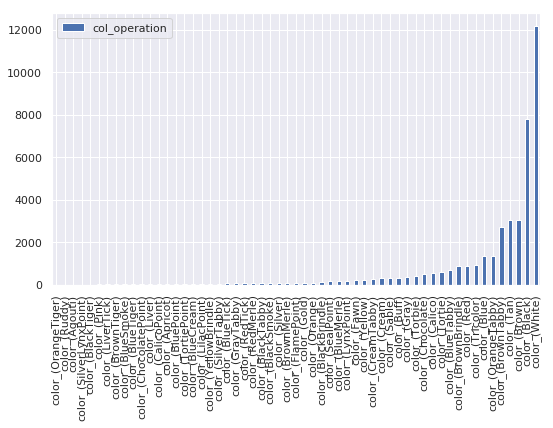

In [124]:
sum_color = col_operation(color, 'sum')
plot(x = sum_color, style = 'barplot')

In [125]:
a = tally(data['sexuponoutcome'],multiple = True,method = 'count')
head(a,10)

,sexuponoutcome_(<NAN>),sexuponoutcome_(Intact Female),sexuponoutcome_(Intact Male),sexuponoutcome_(Neutered Male),sexuponoutcome_(Spayed Female),sexuponoutcome_(Unknown)
0,0,0,0,1,0,0
1,0,0,0,0,1,0
2,0,0,0,1,0,0
3,0,0,1,0,0,0
4,0,0,0,1,0,0
5,0,1,0,0,0,0
6,0,0,1,0,0,0
7,0,0,0,0,0,1
8,0,0,0,0,1,0
9,0,0,0,0,1,0


In [126]:
b = tally(data['animaltype'],multiple = True,minimum = 3,method = 'count')
head(b,10)

,animaltype_(Cat),animaltype_(Dog)
0,0,1
1,1,0
2,0,1
3,1,0
4,0,1
5,0,1
6,1,0
7,1,0
8,0,1
9,0,1


In [127]:
NewData = hcat(color, a,b)
head(NewData, 10)


,color_(Agouti),color_(Apricot),color_(Black),color_(BlackBrindle),color_(BlackSmoke),color_(BlackTabby),color_(BlackTiger),color_(Blue),color_(BlueCream),color_(BlueMerle),color_(BluePoint),color_(BlueSmoke),color_(BlueTabby),color_(BlueTick),color_(BlueTiger),color_(Brown),color_(BrownBrindle),color_(BrownMerle),color_(BrownTabby),color_(BrownTiger),color_(Buff),color_(Calico),color_(CalicoPoint),color_(Chocolate),color_(ChocolatePoint),color_(Cream),color_(CreamTabby),color_(Fawn),color_(FlamePoint),color_(Gold),color_(Gray),color_(GrayTabby),color_(LilacPoint),color_(Liver),color_(LiverTick),color_(LynxPoint),color_(Orange),color_(OrangeTabby),color_(OrangeTiger),color_(Pink),color_(Red),color_(RedMerle),color_(RedTick),color_(Ruddy),color_(Sable),color_(SealPoint),color_(Silver),color_(SilverLynxPoint),color_(SilverTabby),color_(Tan),color_(Torbie),color_(Tortie),color_(TortiePoint),color_(Tricolor),color_(White),color_(Yellow),color_(YellowBrindle),sexuponoutcome_(<NAN>),sexuponoutcome_(Intact Female),sexuponoutcome_(Intact Male),sexuponoutcome_(Neutered Male),sexuponoutcome_(Spayed Female),sexuponoutcome_(Unknown),animaltype_(Cat),animaltype_(Dog)
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1


In [128]:
data = outcome_type_process(data)
Y = data['outcometype']
Y

0        1
1        2
2        3
3        4
4        4
5        4
6        4
        ..
26722    4
26723    3
26724    4
26725    4
26726    3
26727    4
26728    4
Name: outcometype, Length: 26729, dtype: int64

In [129]:
model = Inference(logistic = False)
model.fit(NewData, Y)


Inference(logistic=False)

In [133]:
result = model.coefficients()
head(result, 10)

,coef,P>|z|,sig
animaltype_(Cat),2.450,0.000,@@@
animaltype_(Dog),1.884,0.000,@@@
sexuponoutcome_(Unknown),1.423,0.000,@@@
sexuponoutcome_(Intact Female),1.278,0.000,@@@
sexuponoutcome_(Intact Male),1.133,0.000,@@@
sexuponoutcome_(Spayed Female),0.716,0.000,@@@
sexuponoutcome_(Neutered Male),0.670,0.000,@@@
color_(Yellow),-0.286,0.000,@@@
color_(Silver),-0.459,0.000,@@@
color_(Blue),-0.128,0.000,@@@


In [134]:
result

,coef,P>|z|,sig
animaltype_(Cat),2.450,0.000,@@@
animaltype_(Dog),1.884,0.000,@@@
sexuponoutcome_(Unknown),1.423,0.000,@@@
sexuponoutcome_(Intact Female),1.278,0.000,@@@
sexuponoutcome_(Intact Male),1.133,0.000,@@@
sexuponoutcome_(Spayed Female),0.716,0.000,@@@
sexuponoutcome_(Neutered Male),0.670,0.000,@@@
...,...,...,...
color_(CalicoPoint),0.032,0.867,X
color_(RedMerle),-0.019,0.883,X


In [ ]:
# data = clean(data)
# data = exclude(data, 'animalid')
# data = exclude(data,'name')
# data = exclude(data,'datetime')
# data = exclude(data,'outcomesubtype')
data= exclude(data,['animalid','name','datetime','outcomesubtype','breed'])
data = replace(data, [['Dog',1], ['Cat',2]])
age_process_df = Age_process(data)
#print(head(age_process_df,10))
color_process_data = processcolor(age_process_df)
#print(head(color_process_data, 10))
sex_process_data = sex_process(color_process_data)
#print(head(sex_process_data, 10))
#print(head(outcome_type_process_data, 10))

data

In [ ]:
data = outcome_type_process(sex_process_data)


In [ ]:
Y = data['outcometype']
Y

In [ ]:
X = exclude(data, 'outcometype' )
X

In [ ]:
model = LinearModel(logistic = True, layers = 1)
model.fit(X, Y)


In [ ]:
model.score(model.predict(X), Y)

In [ ]:
model.plot(model.predict(X), Y)

In [ ]:
model.analyse()
